# Elastic Rod Model

In [1]:
from IPython.display import display, Markdown
import random
def latexify(x):
    out = '$' + x + '$'
    return out

def lprint(x):
    display(Markdown(latexify(latex(x))))
    
%run -i 'implicit.py'

import matplotlib.pyplot as plt

In this notebook we attempt to perform computation bifurcation theory on a high dimensional problem

here we consider rods connected by elastic joints that resist angular perturbation, with a forcing action attempting to squash the rod

In [3]:
def get_funcs(n):
    # returns a set of equations to solve

    var_dict = {}
    for i in range(0,n):
        # theta is the angle from the horizontal the ith line branches from
        var_dict['theta{}'.format(i)] = var('theta{}'.format(i), latex_name = r'\theta_{}'.format(i))
        
    var_dict['theta{}'.format(n)] = 0 # will update
        
    # compute the last theta, since must have the endpoints both zero on the vertical
    for i in range(0,n):
        var_dict['theta{}'.format(n)] = var_dict['theta{}'.format(n)] - sin(var_dict['theta{}'.format(i)])
        
    var_dict['theta{}'.format(n)] = arcsin(var_dict['theta{}'.format(n)])
    
    var_dict['l'] = var('l', latex_name=r'\lambda') # compressive force
   
    
    funcs = []
    energy = 0
    for j in range(1,n+1):
        # iterate through each spring in the rod
        e_spring = (var_dict['theta{}'.format(j-1)] - var_dict['theta{}'.format(j)])^2 
        # since pi - (pi - theta0 - theta1) e.g
        energy = energy + e_spring
        
    hoz = 0
    for i in range(0,n+1):
        # total horizontal extension
        hoz = hoz + cos(var_dict['theta{}'.format(i)])
           
    # take away the work done by the force
    energy = energy - var_dict['l']*(n + 1 - hoz)
            
    # solutions will be local minima of the energy equation
    for j in range(0,n):
        #don't care about the last angle
        funcs.append(energy.diff(var_dict['theta{}'.format(j)]))
        
    del var_dict['theta{}'.format(n)] # this was just a latent variable
        
    return funcs, var_dict
    

In [4]:
funcs, var_dict = get_funcs(7)

In [5]:
lprint(funcs[6])

$ -{\left(\frac{{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right) + \sin\left({\theta_2}\right) + \sin\left({\theta_3}\right) + \sin\left({\theta_4}\right) + \sin\left({\theta_5}\right) + \sin\left({\theta_6}\right)\right)} \cos\left({\theta_6}\right)}{\sqrt{-{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right) + \sin\left({\theta_2}\right) + \sin\left({\theta_3}\right) + \sin\left({\theta_4}\right) + \sin\left({\theta_5}\right) + \sin\left({\theta_6}\right)\right)}^{2} + 1}} + \sin\left({\theta_6}\right)\right)} {\lambda} + 2 \, {\left({\theta_6} - \arcsin\left(-\sin\left({\theta_0}\right) - \sin\left({\theta_1}\right) - \sin\left({\theta_2}\right) - \sin\left({\theta_3}\right) - \sin\left({\theta_4}\right) - \sin\left({\theta_5}\right) - \sin\left({\theta_6}\right)\right)\right)} {\left(\frac{\cos\left({\theta_6}\right)}{\sqrt{-{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right) + \sin\left({\theta_2}\right) + \sin\left({\theta_3}\right) + \sin\left({\theta_4}\right) + \sin\left({\theta_5}\right) + \sin\left({\theta_6}\right)\right)}^{2} + 1}} + 1\right)} - 2 \, {\theta_5} + 2 \, {\theta_6} $

In [6]:
var_dict

{'theta0': theta0,
 'theta1': theta1,
 'theta2': theta2,
 'theta3': theta3,
 'theta4': theta4,
 'theta5': theta5,
 'theta6': theta6,
 'l': l}

Compute the Jacobian so we can search for values of $\lambda$ that satisfy the necessary condition

In [11]:
old_var = var_dict
var_dict = {key : var_dict[key] for key in var_dict.keys() if var_dict[key] != 0}
var_dict = {key : var_dict[key] for key in var_dict.keys() if key != 'l'}

J = jacobian(funcs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()}).apply_map(lambda x: x.full_simplify())
lprint(J)

$ \left(\begin{array}{rrrrrrr}
-2 \, {\lambda} + 4 & -{\lambda} & -{\lambda} + 2 & -{\lambda} + 2 & -{\lambda} + 2 & -{\lambda} + 2 & -{\lambda} + 4 \\
-{\lambda} & -2 \, {\lambda} + 6 & -{\lambda} & -{\lambda} + 2 & -{\lambda} + 2 & -{\lambda} + 2 & -{\lambda} + 4 \\
-{\lambda} + 2 & -{\lambda} & -2 \, {\lambda} + 6 & -{\lambda} & -{\lambda} + 2 & -{\lambda} + 2 & -{\lambda} + 4 \\
-{\lambda} + 2 & -{\lambda} + 2 & -{\lambda} & -2 \, {\lambda} + 6 & -{\lambda} & -{\lambda} + 2 & -{\lambda} + 4 \\
-{\lambda} + 2 & -{\lambda} + 2 & -{\lambda} + 2 & -{\lambda} & -2 \, {\lambda} + 6 & -{\lambda} & -{\lambda} + 4 \\
-{\lambda} + 2 & -{\lambda} + 2 & -{\lambda} + 2 & -{\lambda} + 2 & -{\lambda} & -2 \, {\lambda} + 6 & -{\lambda} + 2 \\
-{\lambda} + 4 & -{\lambda} + 4 & -{\lambda} + 4 & -{\lambda} + 4 & -{\lambda} + 4 & -{\lambda} + 2 & -2 \, {\lambda} + 10
\end{array}\right) $

In [12]:
lprint(det(matrix(J))) # potential bifurcation point

$ -8 \, {\lambda}^{7} + 224 \, {\lambda}^{6} - 2496 \, {\lambda}^{5} + 14080 \, {\lambda}^{4} - 42240 \, {\lambda}^{3} + 64512 \, {\lambda}^{2} - 43008 \, {\lambda} + 8192 $

In [13]:
bifs = list(solve(det(matrix(J)), l))
lprint(bifs)

$ \left[{\lambda} = -2 \, \sqrt{2} + 4, {\lambda} = 2 \, \sqrt{2} + 4, {\lambda} = 4, {\lambda} = -\frac{1}{2} \, \sqrt{-16 \, \sqrt{2} + 32} + 4, {\lambda} = \frac{1}{2} \, \sqrt{-16 \, \sqrt{2} + 32} + 4, {\lambda} = -2 \, \sqrt{\sqrt{2} + 2} + 4, {\lambda} = 2 \, \sqrt{\sqrt{2} + 2} + 4\right] $

In [14]:
[float(bif.rhs()) for bif in bifs]

[1.1715728752538097,
 6.82842712474619,
 4.0,
 2.469266270539641,
 5.5307337294603585,
 0.30448186995485305,
 7.695518130045147]

Lets loop throught the bifurcations forces and see the shapes produced as the force increases

In [15]:
bif_tuples = []

# use numerical methods due to high computational cost if solving eigenproblems in closed form
for i in tqdm.tqdm([5,0,3,2,4,1,6]):
    bif_funcs = [func(l = bifs[i].rhs()) for func in funcs]
    J = jacobian(bif_funcs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()}).apply_map(lambda x : float(x))
    # do floating point since we are only looking right now
    K = [epair for epair in J.eigenvectors_right() if abs(epair[0]) < 10e-15][0][1][0] # since float now a solution is found as a highly degenerate eigenvector
    bif_tuples.append((bifs[i].rhs(), K))

100%|██████████| 7/7 [00:00<00:00, 16.21it/s]


In [17]:
def angles_to_coords(angles):
    # produces the coordinates of a line with angles inputted
    coords = []
    coords.append((0,0))
    
    sin_sum = sum([sin(angle) for angle in angles])
    temp_angles = list(angles)
    temp_angles.append(arcsin(-sin_sum))
    
    for angle in temp_angles:
        now = coords[-1]
        new_x = now[0] + cos(angle)
        new_y = now[1] + sin(angle)
        coords.append((new_x, new_y))
        
        
    return coords

In [19]:
def plot_angles(angles, save = False, save_name = 'plot1', folder = 'plots', show = True, title=None):

    plt.axes
    plt.xlim([-1,9])
    plt.ylim([-5,5])

    points = angles_to_coords(tuple(angles))
    for i in range(int(0), int(len(points) - 1)):
        line = plt.Line2D((points[i][0], points[i+1][0]), (points[i][1], points[i+1][1]), lw=2.5)
        plt.gca().add_line(line)
        plt.gca().set_aspect('equal')
        if title is not None:
            plt.title(title)
    if save is True:
        plt.savefig('{}/{}.png'.format(folder, save_name))
        
    if show is True:
        plt.show()
        
    plt.cla()
    return   

We now plot all the potential bifurcation points:

-2*sqrt(sqrt(2) + 2) + 4


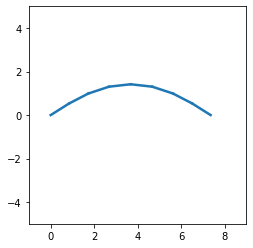

-2*sqrt(2) + 4


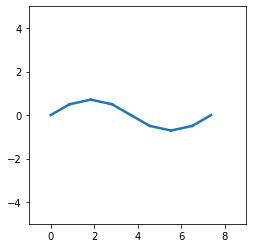

-1/2*sqrt(-16*sqrt(2) + 32) + 4


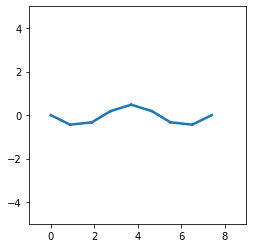

4


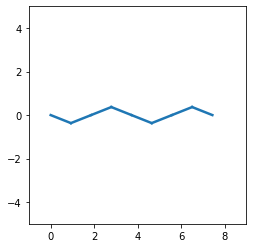

1/2*sqrt(-16*sqrt(2) + 32) + 4


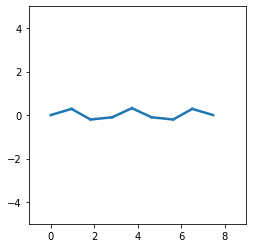

2*sqrt(2) + 4


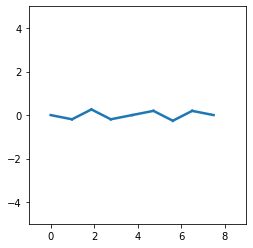

2*sqrt(sqrt(2) + 2) + 4


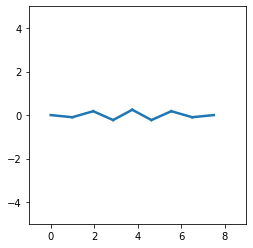

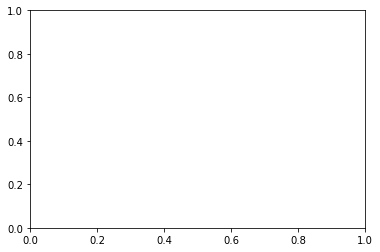

In [21]:
count = 1
for bif_tuple in bif_tuples:
    print(bif_tuple[0])
    plot_angles(bif_tuple[1], save = True, save_name = 'plot{}'.format(count))
    count+=1

Lets do the further investigation with the $\lambda = 4$ case since this will be least computationally intensive

In [22]:
bif_funcs = [func(l = 4) for func in funcs]
J = jacobian(bif_funcs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()})
K = J.right_kernel().basis() # do floating point since we are only looking right now

In [23]:
lprint(J)

$ \left(\begin{array}{rrrrrrr}
-4 & -4 & -2 & -2 & -2 & -2 & 0 \\
-4 & -2 & -4 & -2 & -2 & -2 & 0 \\
-2 & -4 & -2 & -4 & -2 & -2 & 0 \\
-2 & -2 & -4 & -2 & -4 & -2 & 0 \\
-2 & -2 & -2 & -4 & -2 & -4 & 0 \\
-2 & -2 & -2 & -2 & -4 & -2 & -2 \\
0 & 0 & 0 & 0 & 0 & -2 & 2
\end{array}\right) $

### Orthogonalising the kernel

In [24]:
K = J.right_kernel().basis()[0].apply_map(lambda x: x.full_simplify())
lprint(K.apply_map(lambda x: float(x)))

$ \left(1.0,\,-1.0,\,-1.0,\,1.0,\,1.0,\,-1.0,\,-1.0\right) $

In [25]:
lprint(K)

$ \left(1,\,-1,\,-1,\,1,\,1,\,-1,\,-1\right) $

In [26]:
Kperp = matrix(K).right_kernel().basis()
#lprint(Kperp)

In [27]:
A = matrix([K]+Kperp).transpose().apply_map(lambda x: x.full_simplify())
lprint(A)

$ \left(\begin{array}{rrrrrrr}
1 & 1 & 0 & 0 & 0 & 0 & 0 \\
-1 & 0 & 1 & 0 & 0 & 0 & 0 \\
-1 & 0 & 0 & 1 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 & 1 & 0 & 0 \\
1 & 0 & 0 & 0 & 0 & 1 & 0 \\
-1 & 0 & 0 & 0 & 0 & 0 & 1 \\
-1 & 1 & -1 & -1 & 1 & 1 & -1
\end{array}\right) $

In [28]:
key_list = [str(var) for var in var_dict.values()]
value_list = list(A*vector(var_dict.values()))
mutate_dict = dict(zip(key_list, value_list))

In [29]:
mutate_dict

{'theta0': theta0 + theta1,
 'theta1': -theta0 + theta2,
 'theta2': -theta0 + theta3,
 'theta3': theta0 + theta4,
 'theta4': theta0 + theta5,
 'theta5': -theta0 + theta6,
 'theta6': -theta0 + theta1 - theta2 - theta3 + theta4 + theta5 - theta6}

In [30]:
Afuncs = [func(**mutate_dict) for func in bif_funcs]

In [31]:
#lprint(Afuncs) 

In [32]:
Ja = jacobian(Afuncs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()}).apply_map(lambda x: x.full_simplify())
lprint(Ja)

$ \left(\begin{array}{rrrrrrr}
0 & -4 & -4 & -2 & -2 & -2 & -2 \\
0 & -4 & -2 & -4 & -2 & -2 & -2 \\
0 & -2 & -4 & -2 & -4 & -2 & -2 \\
0 & -2 & -2 & -4 & -2 & -4 & -2 \\
0 & -2 & -2 & -2 & -4 & -2 & -4 \\
0 & -4 & 0 & 0 & -4 & -6 & 0 \\
0 & 2 & -2 & -2 & 2 & 2 & -4
\end{array}\right) $

In [33]:
Ka = Ja(l=0).right_kernel().basis()
lprint(Ka)

$ \left[\left(1,\,0,\,0,\,0,\,0,\,0,\,0\right)\right] $

### Orthogonalising the image

In [34]:
I = Ja.image().basis()
I = [Ja*vec for vec in I]
print(len(I))

6


In [35]:
Iperp = matrix(I).apply_map(lambda x: x.full_simplify()).right_kernel().basis()
#lprint(Iperp)

In [36]:
B = matrix(I + Iperp).inverse().apply_map(lambda x: x.full_simplify())
lprint(B)

$ \left(\begin{array}{rrrrrrr}
-\frac{17}{98} & -\frac{9}{49} & \frac{17}{98} & \frac{9}{49} & -\frac{3}{98} & -\frac{2}{49} & \frac{1}{7} \\
-\frac{9}{49} & \frac{65}{392} & -\frac{75}{392} & -\frac{2}{49} & \frac{17}{98} & \frac{9}{392} & -\frac{1}{7} \\
\frac{17}{98} & -\frac{75}{392} & -\frac{19}{392} & -\frac{9}{49} & \frac{3}{98} & \frac{65}{392} & -\frac{1}{7} \\
\frac{9}{49} & -\frac{2}{49} & -\frac{9}{49} & \frac{2}{49} & -\frac{17}{98} & \frac{5}{49} & \frac{1}{7} \\
-\frac{3}{98} & \frac{17}{98} & \frac{3}{98} & -\frac{17}{98} & \frac{11}{98} & -\frac{9}{49} & \frac{1}{7} \\
-\frac{2}{49} & \frac{9}{392} & \frac{65}{392} & \frac{5}{49} & -\frac{9}{49} & -\frac{47}{392} & -\frac{1}{7} \\
\frac{3}{98} & -\frac{19}{392} & \frac{37}{392} & \frac{17}{98} & -\frac{11}{98} & -\frac{75}{392} & -\frac{1}{7}
\end{array}\right) $

In [37]:
tfuncs = vector(Afuncs)*B

In [38]:
#lprint(tfuncs)

In [39]:
Jt = jacobian(tfuncs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()}).apply_map(lambda x: x.full_simplify())

In [40]:
var_dict.values()

dict_values([theta0, theta1, theta2, theta3, theta4, theta5, theta6])

In [41]:
lprint(Jt)

$ \left(\begin{array}{rrrrrrr}
0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0
\end{array}\right) $

In [42]:
latex(Jt)

\left(\begin{array}{rrrrrrr}
0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0
\end{array}\right)

In [43]:
It = Jt.image().basis()
It = [Jt*vec for vec in It]
lprint(It)

$ \left[\left(1,\,0,\,0,\,0,\,0,\,0,\,0\right), \left(0,\,1,\,0,\,0,\,0,\,0,\,0\right), \left(0,\,0,\,1,\,0,\,0,\,0,\,0\right), \left(0,\,0,\,0,\,1,\,0,\,0,\,0\right), \left(0,\,0,\,0,\,0,\,1,\,0,\,0\right), \left(0,\,0,\,0,\,0,\,0,\,1,\,0\right)\right] $

## Adding lambda back in

In [44]:
tfuncs = vector([func(**mutate_dict)(l = l + 4) for func in funcs])*B # now lambda is not fixed at the bifurcation point
# ***IF SOMETHING IS BROKEN CHECK RIGHT LAMBDA HERE***
# but we do shift so that l=0 is the new bifurcation
var_dict['l'] = l

In [45]:
var_dict_old = var_dict
var_dict_old

{'theta0': theta0,
 'theta1': theta1,
 'theta2': theta2,
 'theta3': theta3,
 'theta4': theta4,
 'theta5': theta5,
 'theta6': theta6,
 'l': l}

In [46]:
var_dict.values()

dict_values([theta0, theta1, theta2, theta3, theta4, theta5, theta6, l])

In [47]:
#lprint(tfuncs[1])

## Running the implicit function theorem

In [48]:
len(tfuncs)

7

In [49]:
position = {key : 0 for key in var_dict_old.keys()}
position

{'theta0': 0,
 'theta1': 0,
 'theta2': 0,
 'theta3': 0,
 'theta4': 0,
 'theta5': 0,
 'theta6': 0,
 'l': 0}

In [50]:
#code_funcs = [tfuncs[index].function(*list(var_dict_old.values())) for index in [0,1,2,3,4,5,6]] # careful with computer science indexing from zero
code_funcs = [tfuncs[index] for index in [0,1,2,3,4,5]] # the last function has degenerate first derivative always
position = {key : 0 for key in var_dict_old.keys()}
# var_dict already loaded
var_dict = {'y1' : theta1, 'y2' : theta2, 'y3' : theta3, 'y4' : theta4, 'y5' : theta5, 'y6' : theta6, 'x1' : l, 'x2' : theta0}
x_var_keys = ['l', 'theta0'] # the variables in the kernel
x_dim = 2
y_dim = 6 # invertible part

In [51]:
var_dict.keys()

dict_keys(['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'x1', 'x2'])

In [52]:
t_dict = TensorDict(code_funcs, position, var_dict, x_dim, y_dim)

computing Taylor approximaton to 3 order for speedup


In [53]:
out = get_hkx_polynomial(code_funcs, 3, x_dim, y_dim, var_dict, x_var_keys, t_dict, position)

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


[1 0 0 0 0 0]
[0 1 0 0 0 0]
[0 0 1 0 0 0]
[0 0 0 1 0 0]
[0 0 0 0 1 0]
[0 0 0 0 0 1]


100%|██████████| 4/4 [00:30<00:00,  7.68s/it]


[1 0 0 0 0 0]
[0 1 0 0 0 0]
[0 0 1 0 0 0]
[0 0 0 1 0 0]
[0 0 0 0 1 0]
[0 0 0 0 0 1]


100%|██████████| 14/14 [03:29<00:00, 14.97s/it]


[1 0 0 0 0 0]
[0 1 0 0 0 0]
[0 0 1 0 0 0]
[0 0 0 1 0 0]
[0 0 0 0 1 0]
[0 0 0 0 0 1]


In [54]:
lprint(out) # our h function

$ \left[-\frac{398}{2401} \, {\lambda}^{2} {\theta_0} - \frac{4}{147} \, {\theta_0}^{3} + \frac{2}{49} \, {\lambda} {\theta_0}, \frac{411}{4802} \, {\lambda}^{2} {\theta_0} - \frac{10}{147} \, {\theta_0}^{3} + \frac{5}{49} \, {\lambda} {\theta_0}, \frac{453}{4802} \, {\lambda}^{2} {\theta_0} + \frac{4}{147} \, {\theta_0}^{3} - \frac{2}{49} \, {\lambda} {\theta_0}, -\frac{34}{2401} \, {\lambda}^{2} {\theta_0} + \frac{10}{147} \, {\theta_0}^{3} - \frac{5}{49} \, {\lambda} {\theta_0}, -\frac{76}{2401} \, {\lambda}^{2} {\theta_0} - \frac{6}{49} \, {\theta_0}^{3} + \frac{9}{49} \, {\lambda} {\theta_0}, -\frac{1003}{4802} \, {\lambda}^{2} {\theta_0} - \frac{8}{49} \, {\theta_0}^{3} + \frac{12}{49} \, {\lambda} {\theta_0}\right] $

## Testing the implicit function theorem

In [55]:
subbed = [func(theta1 = out[0],theta2 = out[1], theta3 = out[2], theta4 = out[3], theta5 = out[4], theta6 = out[5]) for func in tfuncs]

In [57]:
[float(func(l = 0.1, theta0 = 0.1)) for func in subbed]  # check that the first six are solved

[-0.00010729963262554043,
 5.021452201396659e-05,
 6.771609026705316e-05,
 4.0313362924260243e-07,
 -2.9115836210461682e-05,
 -0.00014216602500417147,
 -0.010626372799809637]

the last function remains to be solved

### Looking for more solutions

Now substitute this into the equation that had degenerate image

In [58]:
tf_taylor = tfuncs[6].taylor(*[(key,value) for key,value in position.items()],3) # taylor expand the function with degenerate image
# *** CHECK SUBBING INTO CORRECT FUNCTION - SHOULD BE THE LAST ONE ***
lprint(tf_taylor.polynomial(SR)) # all three variables are present

$ \frac{16}{21} \theta_{0}^{3} + \left(-\frac{4}{7}\right) \theta_{0}^{2} \theta_{1} + \frac{12}{7} \theta_{0} \theta_{1}^{2} + \left(-\frac{4}{21}\right) \theta_{1}^{3} + \left(-\frac{4}{7}\right) \theta_{0} \theta_{1} \theta_{2} + \frac{8}{7} \theta_{1}^{2} \theta_{2} + \frac{4}{7} \theta_{0} \theta_{2}^{2} + \left(-\frac{2}{7}\right) \theta_{1} \theta_{2}^{2} + \left(-\frac{2}{7}\right) \theta_{2}^{3} + \left(-\frac{4}{7}\right) \theta_{0} \theta_{1} \theta_{3} + \frac{8}{7} \theta_{1}^{2} \theta_{3} + \frac{4}{7} \theta_{0} \theta_{2} \theta_{3} + \left(-\frac{2}{7}\right) \theta_{1} \theta_{2} \theta_{3} + \left(-\frac{2}{7}\right) \theta_{2}^{2} \theta_{3} + \frac{4}{7} \theta_{0} \theta_{3}^{2} + \left(-\frac{2}{7}\right) \theta_{1} \theta_{3}^{2} + \left(-\frac{2}{7}\right) \theta_{2} \theta_{3}^{2} + \left(-\frac{2}{7}\right) \theta_{3}^{3} + \left(-\frac{4}{7}\right) \theta_{0}^{2} \theta_{4} + \frac{20}{7} \theta_{0} \theta_{1} \theta_{4} + \left(-\frac{8}{7}\right) \theta_{1}^{2} \theta_{4} + \left(-\frac{4}{7}\right) \theta_{0} \theta_{2} \theta_{4} + 2 \theta_{1} \theta_{2} \theta_{4} + \left(-\frac{2}{7}\right) \theta_{2}^{2} \theta_{4} + \left(-\frac{4}{7}\right) \theta_{0} \theta_{3} \theta_{4} + 2 \theta_{1} \theta_{3} \theta_{4} + \left(-\frac{2}{7}\right) \theta_{2} \theta_{3} \theta_{4} + \left(-\frac{2}{7}\right) \theta_{3}^{2} \theta_{4} + \frac{12}{7} \theta_{0} \theta_{4}^{2} + \left(-\frac{8}{7}\right) \theta_{1} \theta_{4}^{2} + \frac{8}{7} \theta_{2} \theta_{4}^{2} + \frac{8}{7} \theta_{3} \theta_{4}^{2} + \left(-\frac{4}{21}\right) \theta_{4}^{3} + \left(-\frac{4}{7}\right) \theta_{0}^{2} \theta_{5} + \frac{20}{7} \theta_{0} \theta_{1} \theta_{5} + \left(-\frac{8}{7}\right) \theta_{1}^{2} \theta_{5} + \left(-\frac{4}{7}\right) \theta_{0} \theta_{2} \theta_{5} + 2 \theta_{1} \theta_{2} \theta_{5} + \left(-\frac{2}{7}\right) \theta_{2}^{2} \theta_{5} + \left(-\frac{4}{7}\right) \theta_{0} \theta_{3} \theta_{5} + 2 \theta_{1} \theta_{3} \theta_{5} + \left(-\frac{2}{7}\right) \theta_{2} \theta_{3} \theta_{5} + \left(-\frac{2}{7}\right) \theta_{3}^{2} \theta_{5} + \frac{20}{7} \theta_{0} \theta_{4} \theta_{5} + \left(-\frac{18}{7}\right) \theta_{1} \theta_{4} \theta_{5} + 2 \theta_{2} \theta_{4} \theta_{5} + 2 \theta_{3} \theta_{4} \theta_{5} + \left(-\frac{8}{7}\right) \theta_{4}^{2} \theta_{5} + \frac{12}{7} \theta_{0} \theta_{5}^{2} + \left(-\frac{8}{7}\right) \theta_{1} \theta_{5}^{2} + \frac{8}{7} \theta_{2} \theta_{5}^{2} + \frac{8}{7} \theta_{3} \theta_{5}^{2} + \left(-\frac{8}{7}\right) \theta_{4} \theta_{5}^{2} + \left(-\frac{4}{21}\right) \theta_{5}^{3} + \left(-\frac{4}{7}\right) \theta_{0} \theta_{1} \theta_{6} + \frac{8}{7} \theta_{1}^{2} \theta_{6} + \frac{4}{7} \theta_{0} \theta_{2} \theta_{6} + \left(-\frac{2}{7}\right) \theta_{1} \theta_{2} \theta_{6} + \left(-\frac{2}{7}\right) \theta_{2}^{2} \theta_{6} + \frac{4}{7} \theta_{0} \theta_{3} \theta_{6} + \left(-\frac{2}{7}\right) \theta_{1} \theta_{3} \theta_{6} + \left(-\frac{2}{7}\right) \theta_{2} \theta_{3} \theta_{6} + \left(-\frac{2}{7}\right) \theta_{3}^{2} \theta_{6} + \left(-\frac{4}{7}\right) \theta_{0} \theta_{4} \theta_{6} + 2 \theta_{1} \theta_{4} \theta_{6} + \left(-\frac{2}{7}\right) \theta_{2} \theta_{4} \theta_{6} + \left(-\frac{2}{7}\right) \theta_{3} \theta_{4} \theta_{6} + \frac{8}{7} \theta_{4}^{2} \theta_{6} + \left(-\frac{4}{7}\right) \theta_{0} \theta_{5} \theta_{6} + 2 \theta_{1} \theta_{5} \theta_{6} + \left(-\frac{2}{7}\right) \theta_{2} \theta_{5} \theta_{6} + \left(-\frac{2}{7}\right) \theta_{3} \theta_{5} \theta_{6} + 2 \theta_{4} \theta_{5} \theta_{6} + \frac{8}{7} \theta_{5}^{2} \theta_{6} + \frac{4}{7} \theta_{0} \theta_{6}^{2} + \left(-\frac{2}{7}\right) \theta_{1} \theta_{6}^{2} + \left(-\frac{2}{7}\right) \theta_{2} \theta_{6}^{2} + \left(-\frac{2}{7}\right) \theta_{3} \theta_{6}^{2} + \left(-\frac{2}{7}\right) \theta_{4} \theta_{6}^{2} + \left(-\frac{2}{7}\right) \theta_{5} \theta_{6}^{2} + \left(-\frac{2}{7}\right) \theta_{6}^{3} + \left(-\frac{8}{7}\right) l \theta_{0} + \frac{2}{7} l \theta_{1} + \frac{2}{7} l \theta_{4} + \frac{2}{7} l \theta_{5} $

In [59]:
tf_sub = tf_taylor(theta1 = out[0],theta2 = out[1], theta3 = out[2], theta4 = out[3], theta5 = out[4], theta6 = out[5]) # substitute in h

In [60]:
local = symbolic_expression(sum([a[0]*a[1] for a in tf_sub.polynomial(SR) if a[1].degree() <= 3]))
#local = tf_sub.polynomial(SR).truncate(4)
lprint(local) # will see that we can take out a factor of theta0 = xi0

$ \frac{12}{343} \, {\lambda}^{2} {\theta_0} + \frac{16}{21} \, {\theta_0}^{3} - \frac{8}{7} \, {\lambda} {\theta_0} $

In [61]:
latex(local)

\frac{12}{343} \, {\lambda}^{2} {\theta_0} + \frac{16}{21} \, {\theta_0}^{3} - \frac{8}{7} \, {\lambda} {\theta_0}

In [62]:
lprint(solve(local, theta0))

$ \left[{\theta_0} = -\frac{1}{14} \, \sqrt{-9 \, {\lambda}^{2} + 294 \, {\lambda}}, {\theta_0} = \frac{1}{14} \, \sqrt{-9 \, {\lambda}^{2} + 294 \, {\lambda}}, {\theta_0} = 0\right] $

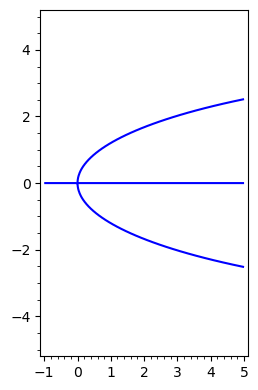

In [63]:
implicit_plot(local, (-1,5), (-5,5))

looks like a bifurcation to me

In [65]:
sols = [solve(local, theta0)[0].rhs()] + [ sol(theta0 = solve(local, theta0)[0].rhs()) for sol in out] # now solutions are spanned by lambda
        # theta0 = g(l)                 # theta_n = h(g(l), l)

In [66]:
len(sols)

7

In [67]:
coords = { list(var_dict_old.keys())[i] : sols[i] for i in [0,1,2,3,4,5,6] }
coords
[tfuncs[i](**coords)(l = 0.01) for i in [0,1,2,3,4,5,6]] # see that we solve both equations

[1.93136248855831e-6,
 -1.28374528715559e-6,
 -1.03942747079833e-6,
 4.26848870662956e-7,
 -4.42692823763332e-8,
 1.98711727109773e-6,
 -2.03258755476223e-6]

However solutions are in the reformed space, need to undo the action that reorganised the kernel

### Generating more solutions

We have solved $f \circ A$ where $A$ orthogonalised the kernel, thus by applying $A$ we can get a traversel of the new solutions.

In [68]:
lprint(A)

$ \left(\begin{array}{rrrrrrr}
1 & 1 & 0 & 0 & 0 & 0 & 0 \\
-1 & 0 & 1 & 0 & 0 & 0 & 0 \\
-1 & 0 & 0 & 1 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 & 1 & 0 & 0 \\
1 & 0 & 0 & 0 & 0 & 1 & 0 \\
-1 & 0 & 0 & 0 & 0 & 0 & 1 \\
-1 & 1 & -1 & -1 & 1 & 1 & -1
\end{array}\right) $

In [69]:
fsols = list(A*vector(sols))
len(fsols)

7

In [70]:
#fsols = [random.random()/10000 for i in range(0,2)] # can check these are giving solutions

In [72]:
coords = { list(var_dict_old.keys())[i] : fsols[i] for i in [0,1,2,3,4,5,6] } 
# *** makes sure it is fsols[i] ***

In [73]:
sym_funcs = [func.function(*list(var_dict_old.values()))(l = l + 4) for func in funcs] # convert to symbolic functions
# *** IF SOMETHING IS BREAKING CHECK THAT RIGHT SHIFT HERE ***

In [74]:
vector([float(func(**coords)(l = 0.01)) for func in sym_funcs])

(-7.283595137586989e-06, -3.7070556607700844e-06, -2.0939279230653123e-07, -3.820967228557095e-06, -1.0816293018275198e-05, -7.134642188059244e-06, 3.3583481402186567e-06)

We see that these solutions do indeed comprise a new set of solutions

In [75]:
for i in range(0,10):
    to_print = [float(i/100)]
    for j in [0,1,2,3,4,5,6]:
        to_print.append(round(float(fsols[j](l = i/100)), 4))
    print(*to_print)

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.01 -0.1225 0.1225 0.1225 -0.1225 -0.1225 0.1225 0.1225
0.02 -0.1731 0.1731 0.1731 -0.1732 -0.1732 0.1732 0.1732
0.03 -0.212 0.212 0.212 -0.212 -0.212 0.2121 0.2121
0.04 -0.2447 0.2448 0.2448 -0.2448 -0.2448 0.2449 0.2449
0.05 -0.2735 0.2736 0.2736 -0.2736 -0.2736 0.2738 0.2738
0.06 -0.2995 0.2996 0.2996 -0.2997 -0.2997 0.2999 0.2999
0.07 -0.3234 0.3235 0.3235 -0.3237 -0.3236 0.324 0.324
0.08 -0.3456 0.3458 0.3458 -0.3459 -0.3459 0.3464 0.3464
0.09 -0.3664 0.3667 0.3666 -0.3669 -0.3668 0.3675 0.3675


\\/\ bending action

100%|██████████| 500/500 [01:27<00:00,  5.69it/s]


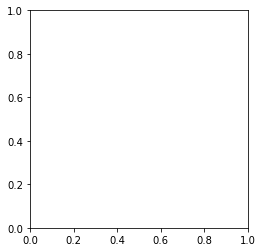

In [68]:
for i in tqdm.tqdm(range(0,500)):
    
    angles = [fsol(l = i/1000) for fsol in fsols]
    plot_angles(angles, save = True, save_name = 'multi/plot{}'.format(str(i)), show = False, title = 'lambda = 4.{}'.format(f'{i:03d}'))